In [1]:
from main import COCODataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [17]:
ds = COCODataset('data/train', 'data/annotations.json', intix=True)
sizes = []
for img, ann in ds:
    labels = ds.lenc.inverse_transform(ann['labels'])
    c, h, w = img.shape
    area = ann['area'] / (h * w)
    for label, p_area in zip(labels, area):
        sizes.append({'id': ann['id'].item(), 'label': label, 'area': p_area.item()})

In [18]:
df = pd.DataFrame.from_records(sizes)
df.head()

,id,label,area
0,1307,carrot,0.014739
1,1307,carrot,0.000735
2,1307,carrot,0.000379
3,1355,bowl,0.000181
4,1355,bowl,0.000314


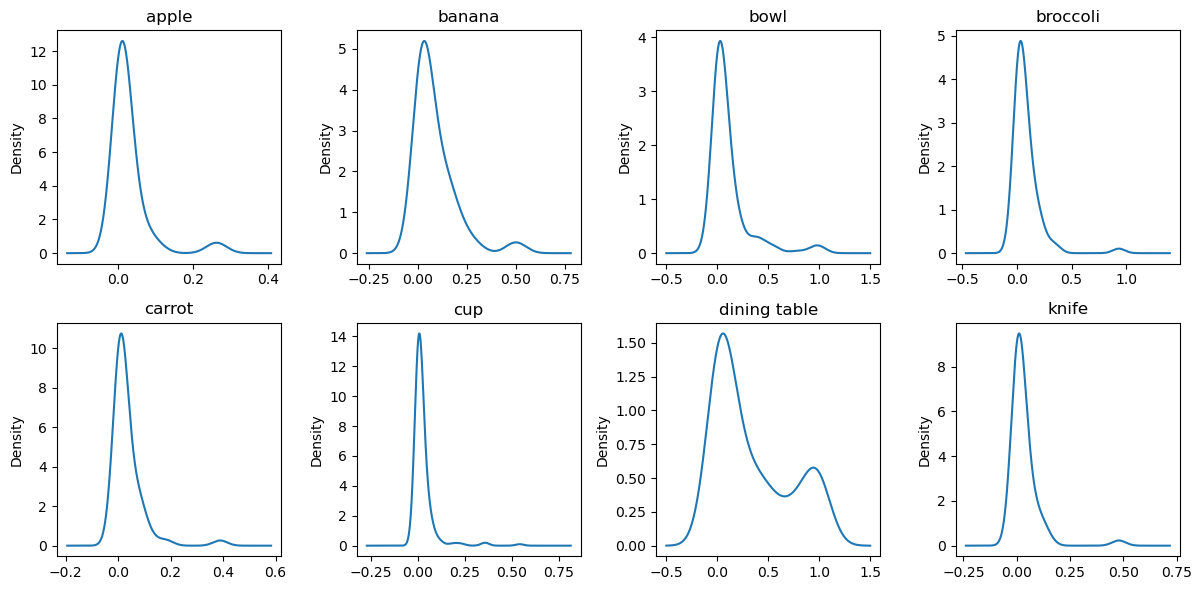

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
ax = ax.ravel()
for (label, xdf), a in zip(df.groupby('label'), ax):
    xdf['area'].plot(kind='kde', ax=a)
    a.set_title(label)
plt.tight_layout()

In [31]:
# Dining tables seem bimodal

<AxesSubplot:>

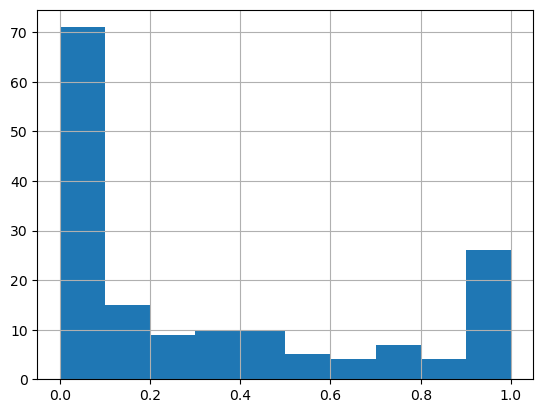

In [33]:
df[df['label'] == 'dining table']['area'].hist()

In [42]:
df['dt_label'] = np.where(df['area'] > 0.5, "large", "small")

In [43]:
df.loc[df['label'] != 'dining table','dt_label'] = 'none'

In [44]:
df['dt_label'].value_counts()

none     611
small    114
large     47
Name: dt_label, dtype: int64

In [45]:
# Combine these with the cluster labels now

In [46]:
df['label'] = df['label'].str.replace(' ', '_')

In [49]:
docs = df.groupby('id')['label'].apply(lambda x: ' '.join(x))

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

In [51]:
vect = CountVectorizer()
X = vect.fit_transform(docs)

In [57]:
clus_labels = KMeans().fit(X).labels_

In [62]:
xx = pd.crosstab(index=df['id'], columns=df['dt_label'])
xx['label'] = ''
xx.loc[xx[['large', 'small']].sum(axis=1) == 0, 'label'] = 'none'

In [64]:
dt_ix = xx[xx[['large', 'small']].sum(axis=1) > 0].index

In [69]:
xx.loc[dt_ix, 'label'] = xx.loc[dt_ix][['large', 'small']].idxmax(axis=1)

In [71]:
xx['label'].value_counts()

none     88
small    68
large    44
Name: label, dtype: int64

In [73]:
(xx.index == docs.index).all()

True

In [74]:
xx['clus_id'] = clus_labels

In [76]:
xx.head()

dt_label,large,none,small,label,clus_id
id,,,,,
1307,0,3,0,none,4
1355,0,4,0,none,0
3579,0,3,0,none,3
4579,0,9,0,none,2
10303,1,3,0,large,1


In [77]:
from sklearn.model_selection import train_test_split

In [80]:
_ = train_test_split(xx, stratify=xx['clus_id'])

In [82]:
(xx['label'] + xx['clus_id'].astype(str)).value_counts()

small5    31
none3     25
large5    20
none5     16
large3    14
small3    14
none0     13
small6    12
none1     11
none7      9
none4      8
small0     8
none2      6
large0     6
large1     2
large2     2
small1     1
small2     1
small7     1
dtype: int64